## BAYES CLASSIFICATION and GAUSSIAN MODELS
### EXAMPLE:  RECOGNIZE GENDER FROM PITCH

Purpose:  do one of the simplest tasks in machine learning

We make use of the Hillenbrand database and a simple Bayesian model.
We make use of the scikit-learn toolkit and our own pyspch wrapper around it for multiclass applications.


### 1. Setting up your Python Environment
The first code block imports required modules into the Python environment 
1. First a set of imports takes care of a default Python's Machine Learning Stack
    + i.e. a number of modules that are used across a very wide range of machine learning tasks
        - scipy, numpy & pandas are used for data manipulation and computations
        - matplotlib and seaborn are used for plotting
        - sklearn is Python's elementary machine learning toolkit
    + these imports are generous, we may not be using all of them; though at the same time, this is limited to the basics
    
2. We also import some local utilities that are needed for this exercise
    + These utilities are not part of any standard Python environment
    + Depending on where and how you run this file, you may have to modify the variable 'environment' 

In [11]:
# Importing Python's baseline machine learning stack 
#
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio

# imports from the scikit-learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git
except:
  IN_COLAB = False

from pyspch.io.hillenbrand import fetch_hillenbrand, select_hillenbrand
#
# installing a colorpalette and markers that can handle the 12 class data 
colors = ['blue','green','red','magenta','maroon', 'darkorange','steelblue', 'darkviolet', 'gold','limegreen',   'darkkhaki', 'cyan','skyblue', ]
markers = ('o', 'P','v', '^', '<', '>', 'X','8', 's', '*', 'h', 'H', 'D', 'd', 'P','p')
#
#cp = sns.color_palette(colors12)
#sns.set_palette(cp)
#sns.palplot(cp)
# 
np.set_printoptions(precision=2)

### 2. The Database 
All experiments in this notebook are using (parts of) the Hillenbrand '95 database. For details see DataExploration.ipynb notebook
http://homes.esat.kuleuven.be/~spchlab/datasets/hillenbrand/README.txt


In [2]:
hildf = fetch_hillenbrand(genders='adults').dropna()
X = np.array(hildf.loc[:,['f0']])
y = np.array(hildf.loc[:,'gender'])
classes = np.unique(y)
print(hildf.head())


      gender vowel     f0     F1      F2      F3
fid                                             
m01ae      m    ae  174.0  663.0  2012.0  2659.0
m02ae      m    ae  102.0  628.0  1871.0  2477.0
m03ae      m    ae   99.0  605.0  1812.0  2570.0
m04ae      m    ae  124.0  627.0  1910.0  2488.0
m06ae      m    ae  115.0  647.0  1864.0  2561.0


### 3. Model Exploration

All machine learning tasks start with a data exploration phase in which we try to understand a bit more of how the data is distributed over the different classes.
This may give us a hint as to which paradigm may be the best suited for tackling our problem.

#### Data Analysis of the unlabeled data -- Fitting with Gaussian Mixture Models
Gaussian Mixture Models are a popular method for fitting unknown densities. Sometimes the multiclass nature of the data will show up as a clear multimodal fit to the data.
In such cases the GMM fit can be used to discover the individual classes and GMMs can be used for clustering. If the number of gaussians does not match the number of classes or if the multimodal nature is not sufficiently pronounced then a blind clustering procedure with GMMs will yield a fuzzy result.
So the procedure only works well if classes are rather well separated and the number of classes is known in advance.

In our case (f0 data of a mixed male/female) we can expect 2 clusters with quite well separated distributions that are more or less Gaussian on top of that.
To further investigate the above we make fits to the data with 1,2,3 and 4 mixtures.

We make use of the *GaussianMixture()* module in the **sklearn** package.

##### Tasks & Questions (1)
1. In which cases do we see underfitting or overfitting
2. In which cases do the individual means of the distributions give you common sense information about the distribution of either class
3. If you like to see what happens, with larger number of Gaussians, change the parameter max_gaussians = ... to a different number
4. Does the Gaussian mixture model fit the data well ?

ng=1:   [[176.99]]
ng=2:   [[130.34 221.01]]
ng=3:   [[157.37 223.25 122.76]]
ng=4:   [[209.8  235.57 115.4  145.96]]


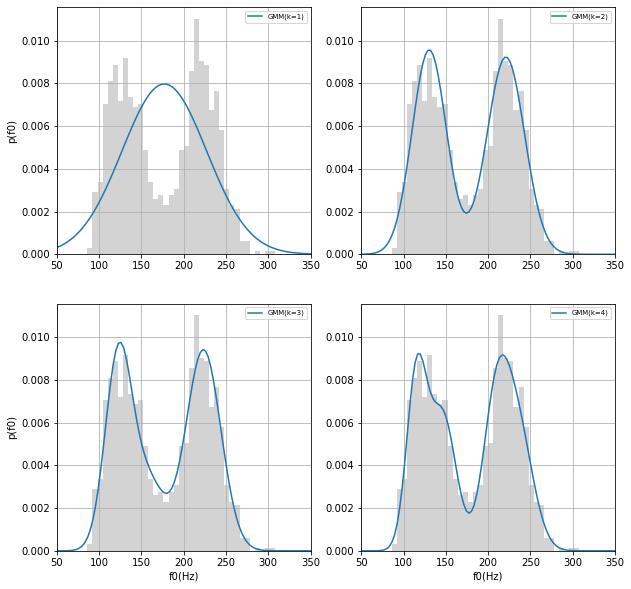

In [3]:
#from sklearn.mixture import GaussianMixture
max_gaussians = 4
nrows = int((max_gaussians+1)/2)

xmin =50.
xmax=350.
xp = np.linspace(xmin,xmax,100).reshape(-1,1)
# you need to do this reshaping as it expects 2D data with shape (n_samples,n_features)
 
fig, ax = plt.subplots(nrows,2, sharex=False, sharey=False, figsize=(10,10))
for i in range(0,max_gaussians) :
    ncomp = i+1
    gmm = GaussianMixture(max_iter=10,random_state=1,n_components=ncomp,init_params='kmeans')
    gmm.fit(X)
    print("ng=%d:  " % ncomp,gmm.means_.T)
    yp = gmm.score_samples(xp)  # returns the logprob of GMM likelihoods
    ii = int(i/2); jj=i%2
    ax[ii,jj].hist(X,bins=50,range=(xmin,xmax),density=True,color='lightgrey')
    ax[ii,jj].plot(xp,np.exp(yp),label='GMM(k=%d)' % ncomp)
    ax[ii,jj].set_xlim(xmin,xmax)
    if jj == 0:
        ax[ii,jj].set_ylabel('p(f0)')
    if ii == 1:
        ax[ii,jj].set_xlabel('f0(Hz)')
    ax[ii,jj].legend(loc='upper right',fontsize='x-small')
    ax[ii,jj].grid(True,which='major',axis='both')
plt.show()

##### Answers (1)
- (Q1&Q3) It is quite obvious that the 1-mixture fit yields a gross underfitting of the data.   The 3 and 4 mixture fits give additional information that is hard to interpret and it is probably nothing more than exhibition of overfitting. 
- (Q2) As expected the 2-mixture fit captures the  bimodal distribution very well.  Only in this case we may find rather expected mean values for pitch of male and female, respectively 130Hz and 220Hz.
- (Q4) The Gaussian mixture model does a pretty good job.  Obvious a gaussian distribution is not 'physically' correct as it gives a finite distribution to negative pitches or very high pitches while we know that no such pitches can not exist.

#### Data Analysis of the labeled data

If we may assume that all our data has been (correctly) labeled, then we get a better view of the data. For 1-D observations, as in this case, we still observe with histograms, for higher dimensional data we will use scatter plots. 
The plot below shows a simple 2 class histogram 

It may all look simple and trivial. However, some intuitive assumptions may rightfully be questioned.  We will explore two such things:  the number of bins in the histogram and the scaling of
the feature axis.

##### Tasks & Questions (2):
1. The principle parameter that you can adjust in the code block below is the 'n_bins' parameter.  It sets the number of bins in the histograms.  There is no ABSOLUTE trutch value for n_bins. Try to explain how n_bins is related to the size of your database, the number of classes and/or the dimensionality of the feature vectors ?
2. Up till now we expressed pitch in the common physical unit 'Hz'.  However, from a musical perspective it is more common to express pitch on a musical/logarithmic scale.  In Western music an octave is divided into 12 equal parts on a logartihmic scale, also called *semitones*. Be aware that such musical scale, just as any other logarithmic scale, is a relative scale.  Do you see differences in how the data is distributed on a Hz or on a semitone scale ?  Is the Gaussian assumption work better for either scale ?  

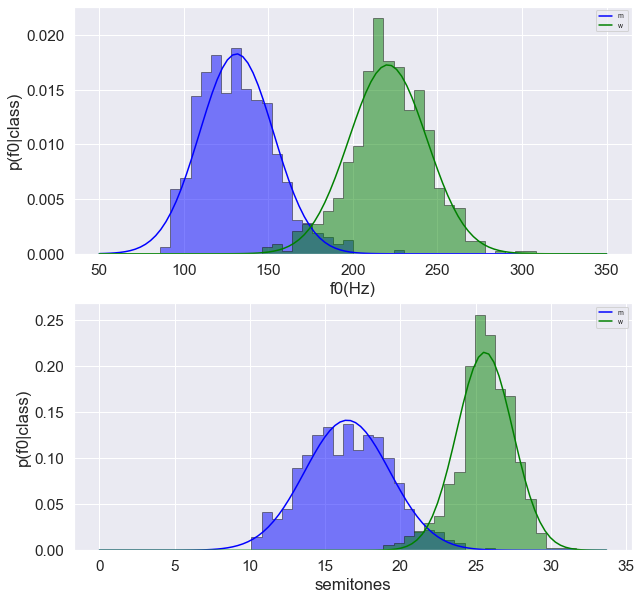

In [15]:
freq_scale = "Hz"                    # should be 'Hz' or 'semitones'
fit_gaussians = True                 # should be True or False
n_bins = 50                          # number of bins in the histograms
f0_range = np.asarray([50., 350.])   # frequency range in histograms
f0base = 50.                         # reference frequency (in Hz) for semitone scale

plt.close('all')
def freq2st(f,base=f0base):
    return 12*np.log2(f/base)

#
x1 = X[y=='m',:]
x2 = X[y=='w',:]
y1 = y[y=='m']
y2 = y[y=='w']

xlab = 'f0(Hz)'
ylab = 'p(f0|class)'

fig,ax = plt.subplots(2,1,figsize=(10,10))

for i in range(0,2):    
    if i == 1:
        x1= freq2st(x1)
        x2= freq2st(x2)
        f0_range = freq2st(f0_range)
        xlab = 'semitones'
    kwargs = dict(histtype='stepfilled', alpha=.5, bins=n_bins, density=True, ec="k")
    ax[i].hist(x1, **kwargs,range=f0_range,color=colors[0])
    ax[i].hist(x2, **kwargs,range=f0_range,color=colors[1])
    ax[i].set_xlabel(xlab)
    ax[i].set_ylabel(ylab)
    ax[i].grid(True)
    if(fit_gaussians):
        xp  = np.linspace(f0_range[0],f0_range[1],100).reshape(-1,1)
        for j in range(0,2):
            if(j==0):
                xdata = x1
            else:
                xdata = x2
            gmm = GaussianMixture(max_iter=3,random_state=1,n_components=1,init_params='kmeans')
            gmm.fit(xdata)
            yp = gmm.score_samples(xp)
            ax[i].plot(xp,np.exp(yp),label='%s ' % classes[j],color=colors[j])
        ax[i].legend(loc='upper right',fontsize='x-small')

plt.show()

### 4. Classification using a Bayesian classifier and Gaussian models

We know now enough to create and test our classifier
1. split the data in  training set and  test set
    -  X_train, y_train, X_test, y_test
2. train the classifier based on the training data
    - given the data exploration before we choose to model the data in each class with a single Gaussian distribution 
3. construct a classifier using the Bayesian rule and posteriors
4. evaluate on test data; look at overall score 
5. look more in detail to a confusion matrix (next codeblock)

For this, we will use the class *GaussianMixtureClass* which is provided in *spchutils* .
It is implemented as an extension to *sklearn*, making use of the sklearn GaussianMixture density estimator, as we used before. 

There are a number of parameters that you may adjust in the following code blocks
- n_components:  the number of mixtures used in the Gaussian MM
- train_size:    the proportion of the data that will be used for training, the remainder is used for testing
- priors_test:   
- random_state:  you can modify this to have a different division between train and test sets and see if you get different results


##### Task & Questions (3)
1. What Accuracy do you obtain ?
2. Do you observe great variability on accuracy when you modify the number of Gaussian components or the amount of training data that is used ?  What does this tell you ?
3. Specify different priors_test: (i)  specify 80% prior for males (ii) specify 100% prior for female.   What happens to the overall accuracy and confusion matrix ? Explain why things are going worse.

In [5]:
from pyspch.GaussianMixtureClf import GaussianMixtureClf
# --------------
n_components = 1
train_size=0.5
random_state=0     # sets initialization of RNG for selecting train/test data, set to None to be random
priors_test = None # should be None or a vector of type e.g. [0.8 , 0.2] expects 80% male
# --------------
# 1. select non-overlapping train and test sets
test_size=1.0 - train_size
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=random_state)
clf_GM = GaussianMixtureClf(classes=classes,n_components=n_components)
clf_GM.fit(X_train,y_train)
# 2. print the model
clf_GM.print()
#print("Classes: ",clGM.classes_)
y_pred = clf_GM.predict(X_test,priors=priors_test)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

Class[0] (m) with prior=0.495
-----------------------------------
   weights        mean    std_dev
0      1.0  130.481481  20.568171
Class[1] (w) with prior=0.505
-----------------------------------
   weights        mean    std_dev
0      1.0  221.145455  22.304193
Accuracy: 94.86%


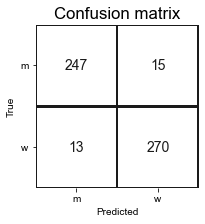

Accuracy: 94.86%


In [6]:
# A Confusion Matrix gives a more detailed image of the errors that we make
# The routine makes for pretty printing
def plot_confusion_matrix(cm,labels=[],cmap=[]):
    import seaborn as sns

    if len(labels) == 0 :
        df_cm = pd.DataFrame(cm)
    else:
        df_cm = pd.DataFrame(cm, labels, labels)
        
    f,ax = plt.subplots(figsize=(3,3))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,fmt="d",annot_kws={"fontsize": 14,"color":'k'},
                square=True,linecolor='k',linewidth=1.5,cmap=cmap,cbar=False)
    ax.tick_params(axis='y',labelrotation=0.0,left=True)
    # font size
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

y_pred = clf_GM.predict(X_test, priors=[.5 , .5])
cmat = skmetrics.confusion_matrix(y_test,y_pred)
#print('Confusion Matrix:\n',cmat)    
    
plot_confusion_matrix(cmat,labels=classes)
print('Accuracy: %.2f%%' % (100.0*skmetrics.accuracy_score(y_test, y_pred)))

In [7]:
# Instead of using a single fixed split between train and test
# we often prefer to evaluate using a cross validation procedure
# For this we split the full data randomly in Nfolds of roughly equal size
# Then we take each of the folds as test_set and train on all remaining folds
# Finally we average the results
# This procedure is especially useful for small datasets.
# For this problem the dataset is big enough and a simple train/test split did the job
nfolds = 10
scores = cross_val_score(clf_GM, X, y, cv=nfolds)
print("Average Cross validation score for %d folds: %.2f %% correct" % (nfolds,100.0*np.average(scores)))

Average Cross validation score for 10 folds: 95.96 % correct


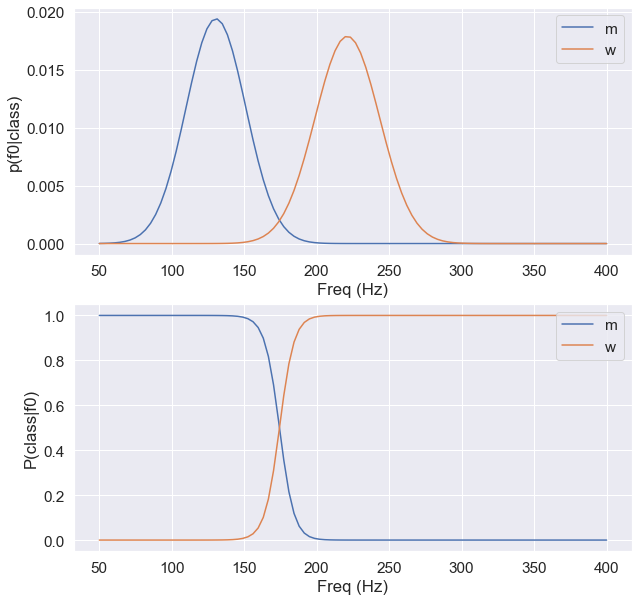

In [16]:
# have a look at the internals of the classifier
# by looking at likelihoods per class and 
# predicted probabilities per class over the whole pitch range
x = np.vstack(np.linspace(50.,400.,100))
fig,ax = plt.subplots(2,1,figsize=(10,10))

# 1. likelihoods
z = clf_GM.predict_prob(x)
h = ax[0].plot(x,z)
ax[0].set_xlabel("Freq (Hz)")
ax[0].set_ylabel("p(f0|class)")
ax[0].legend(classes,loc='upper right')
ax[0].grid(True)
# 2. posteriors
z = clf_GM.predict_proba(x)
h = ax[1].plot(x,z)
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("P(class|f0)")
ax[1].legend(classes,loc='upper right')
ax[1].grid(True)
ax[1].set_xticks(x,minor=True)
plt.show()

#### 5. Can you do it yourself ?

Do you really understand all the underlying formulas that are being used.
You should be able to do predictions yourself on the basis of the model parameters .. and you don't need a calculator.

##### Task & Questions (4)
1. Get a detailed printout of your current model
2. Create an independet test vector in my_test, with values of your choice
3. Run the predictions made by the model
4. Now try to replicate all computations for one of the values
5. Given your classifier, can you make a prediction on the global error rate ? 
6. Include 135Hz and 145Hz in the test samples.  First, observe that in the full Hillenbrand database the lowest female pitch is 149Hz. What would your intuitive answer (guess) be on classification and posteriors.  Now observe the predictions given by the model. How do you explain the rather big differences beween the two predicted posteriors ?

<img src="normal_distribution.png" style="height:10cm"/>

In [9]:
my_test = np.array([89., 135., 145., 173., 199., 240., 112., 288.]).reshape(-1,1)
priors=None
# verify the values of the model
clf_GM.print()
#
print(clf_GM.predict_proba(my_test,priors=priors))
print(clf_GM.predict(my_test,priors=priors))

Class[0] (m) with prior=0.495
-----------------------------------
   weights        mean    std_dev
0      1.0  130.481481  20.568171
Class[1] (w) with prior=0.505
-----------------------------------
   weights        mean    std_dev
0      1.0  221.145455  22.304193
[[1.00e+00 1.71e-07]
 [9.99e-01 5.54e-04]
 [9.96e-01 3.54e-03]
 [5.64e-01 4.36e-01]
 [6.74e-03 9.93e-01]
 [1.06e-06 1.00e+00]
 [1.00e+00 8.88e-06]
 [1.75e-11 1.00e+00]]
['m', 'm', 'm', 'm', 'w', 'w', 'm', 'w']
